/tmp/ipykernel_146067/3095288452.py:66: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(start='2024-08-01', periods=min_length+0, freq='H')


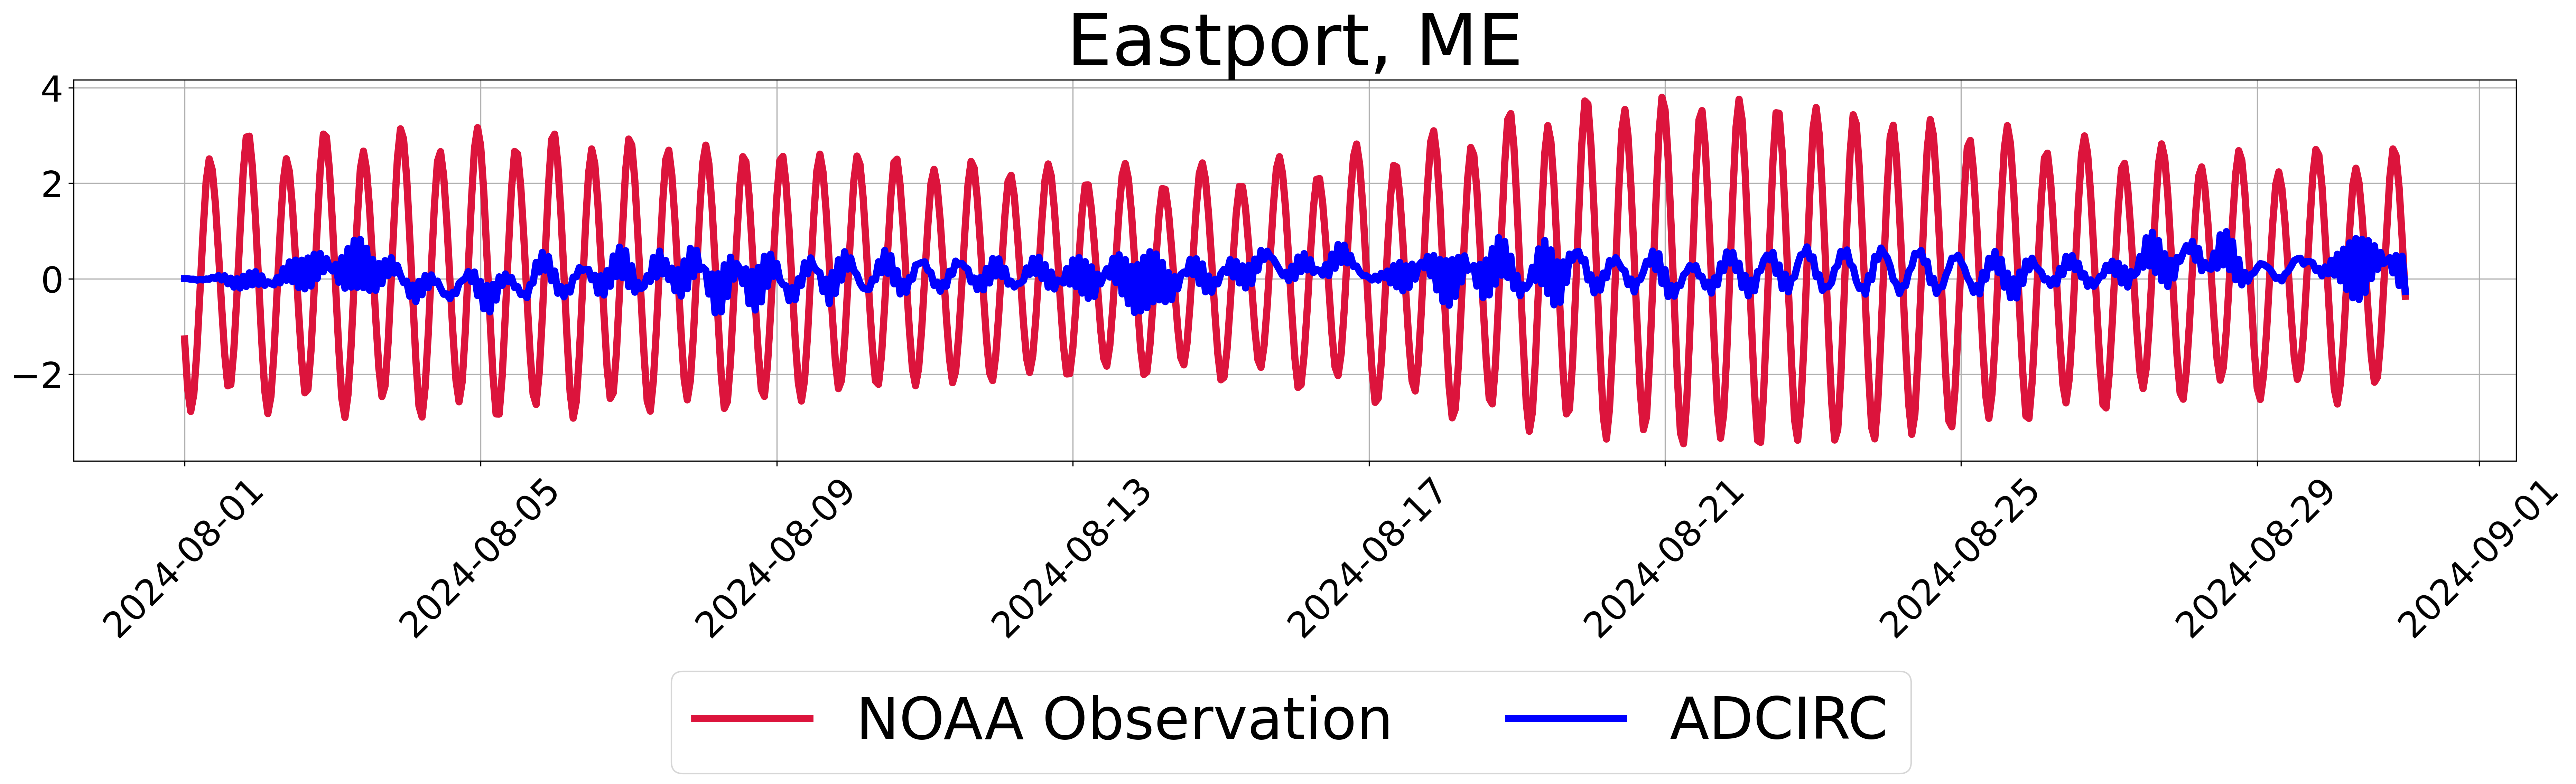

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from netCDF4 import Dataset

stations_and_nodes = [
    # {'station': '8632200', 'node': 514417, 'name': 'Kiptopeke, VA'},
    # {'station': '8638901', 'node': 520058, 'name': 'CBBT, VA'},
    # {'station': '8654467', 'node': 323049, 'name': 'Hatteras, NC'},
    # {'station': '8656483', 'node': 357301, 'name': 'Beaufort, NC'},
    # {'station': '8658120', 'node': 19758, 'name': 'Wilmington, NC'},
    # {'station': '8665530', 'node': 312580, 'name': 'Charleston, SC'},
    # {'station': '8724580', 'node': 316898, 'name': 'Vaca Key, FL'},
    # {'station': '8726384', 'node': 183795, 'name': 'Port Manatee, FL'},
    # {'station': '8726520', 'node': 164415, 'name': 'Tampa Bay, FL'},
    # {'station': '8727520', 'node': 207787, 'name': 'Cedar Key, FL'},
    # {'station': '8766072', 'node': 189052, 'name': 'Canal Locks, LA'},
    {'station': '8537121', 'node': 497919, 'name': 'Shipjohn Shoal, NJ'},
]

# Load NetCDF files
withoutoffset_path = '/scratch/07174/soelem/global_2-20km/fort.63.nc'
withoffset_path = '/scratch/07174/soelem/global_test_like_pringle/fort.63.nc'

try:
    withoutoffset = Dataset(withoutoffset_path, 'r')
    withoffset = Dataset(withoffset_path, 'r')
except OSError as e:
    print(f"Error loading NetCDF files: {e}")
    exit(1)

# Set the start and end time for the plots
start_time = '2024-08-01'
end_time = '2024-08-31'

# Convert start and end time to pandas datetime
start_time = pd.to_datetime(start_time)
end_time = pd.to_datetime(end_time)

# Create subplots
if len(stations_and_nodes) == 1:
    fig, axs = plt.subplots(1, 1, figsize=(25, 5), dpi=300)
    axs = [axs]  # Make it iterable
else:
    fig, axs = plt.subplots(len(stations_and_nodes), 1, figsize=(26, 12), dpi=600, sharex=True)

for i, station_info in enumerate(stations_and_nodes):
    node_index = station_info['node'] - 1  # Adjusting node index for Python indexing
    withoutoffset_data = withoutoffset.variables['zeta'][:, node_index]
    withoffset_data = withoffset.variables['zeta'][:, node_index]

    # Find the minimum length to ensure alignment
    min_length = min(len(withoutoffset_data), len(withoffset_data))

    # Adjust the data and dates array lengths
    withoutoffset_data = withoutoffset_data[:min_length]
    withoffset_data = withoffset_data[:min_length]

    # Adjust the phase by shifting
    withoutoffset_data_shifted = np.roll(withoutoffset_data, 0)[:min_length+0]
    withoffset_data_shifted = np.roll(withoffset_data, 0)[:min_length+0]

    # Generate the dates array
    dates = pd.date_range(start='2024-08-01', periods=min_length+0, freq='H')

    # Filter the dates based on the start and end time
    mask = (dates >= start_time) & (dates <= end_time)
    dates = dates[mask]
    withoutoffset_data_shifted = withoutoffset_data_shifted[mask]
    withoffset_data_shifted = withoffset_data_shifted[mask]

    # Calculate the residual SSH
    residual_ssh = withoffset_data_shifted - withoutoffset_data_shifted

    # NOAA tide data preparation
    url = f'https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?begin_date={start_time.strftime("%Y%m%d")}&end_date={end_time.strftime("%Y%m%d")}&station={station_info["station"]}&product=water_level&datum=MSL&time_zone=lst&units=metric&format=csv'
    try:
        noaa_data = pd.read_csv(url, parse_dates=['Date Time'], usecols=['Date Time', ' Water Level']).dropna()
        noaa_data.set_index('Date Time', inplace=True)
        noaa_data = noaa_data.reindex(dates, method='nearest')
    except Exception as e:
        print(f"Error loading NOAA data for station {station_info['station']}: {e}")
        continue

    axs[i].plot(dates, noaa_data[' Water Level'].values, label='NOAA Observation', color='crimson', linestyle='-', linewidth=5)
    axs[i].plot(dates, withoutoffset_data_shifted, label='ADCIRC', linestyle='-', linewidth=5, color='blue')
    # axs[i].plot(dates, withoffset_data_shifted, label='With Offset', linestyle='-', linewidth=5, color='darkgreen')
    # axs[i].plot(dates, residual_ssh, label='Residual SSH', linestyle='-', linewidth=5, color='red')

    axs[i].set_title('Shipjohn Shoal, NJ', fontsize=50)
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axs[i].tick_params(axis='x', rotation=45, labelsize=25)  # Adjust the labelsize here
    axs[i].tick_params(axis='y', labelsize=25)
    axs[i].grid(True)

# Adjust the last axis to create space for the legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=3, fontsize='40')

plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
plt.show()